# Exporting data to GeoTIFF files <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Background

At the end of an analysis it can be useful to export data to a GeoTIFF file (e.g. `outputname.tif`), either to save results or to allow for exploring results in a GIS software platform (e.g. ArcGIS or QGIS).

## Description

This notebook shows a number of ways to export a GeoTIFF file:

1. Exporting a single-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
2. Exporting a multi-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
3. Exporting multiple GeoTIFFs, one for each time-slice of an xarray object loaded through a `dc.load` query
4. Exporting a single-band GeoTIFF when handling a simple array and/or an xarray that doesn't contain `transform`, `crs` or `affine` metadata

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [6]:
%matplotlib inline

import datacube
from datacube.helpers import write_geotiff
from datacube.utils.cog import write_cog
import numpy as np
import xarray as xr
import sys

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs, array_to_geotiff
from deafrica_plotting import rgb


### Connect to the datacube

In [5]:
dc = datacube.Datacube(app='Exporting_GeoTIFFs')


## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [3]:
lat, lon = 13.94, -16.54
buffer = 0.1

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2016-06', '2017-06'),
    'resolution': (-30, 30),
    'measurements': ['red', 'green', 'blue']
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              min_gooddata=0.99, 
              output_crs=output_crs,
              align=(15, 15),
              **query)

# Print output data
print(ds)


Loading ls8_usgs_sr_scene data
    Using pixel quality parameters for USGS Collection 1
    Filtering to 4 out of 72 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 4 observations 
<xarray.Dataset>
Dimensions:  (time: 4, x: 726, y: 743)
Coordinates:
  * y        (y) float64 1.553e+06 1.553e+06 1.553e+06 ... 1.531e+06 1.531e+06
  * x        (x) float64 3.227e+05 3.228e+05 3.228e+05 ... 3.445e+05 3.445e+05
  * time     (time) datetime64[ns] 2016-06-19T11:27:11.943752 ... 2017-04-19T11:26:52.881313
Data variables:
    red      (time, y, x) float32 740.0 740.0 645.0 ... 1176.0 1046.0 914.0
    green    (time, y, x) float32 734.0 740.0 641.0 596.0 ... 970.0 875.0 787.0
    blue     (time, y, x) float32 451.0 465.0 318.0 284.0 ... 655.0 578.0 505.0
Attributes:
    crs:      epsg:32628


### Plot an rgb image to confirm we have data

The white regions are cloud cover.

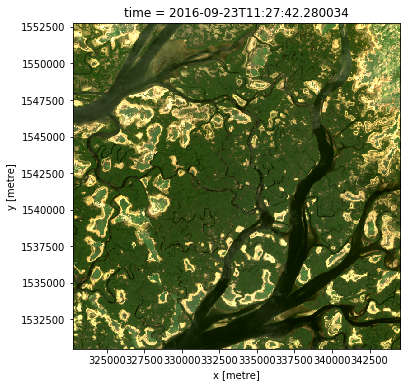

In [4]:
rgb(ds, index=1)


### Export a single-band, single time-slice GeoTIFF

This method uses the `datacube.helpers` function `write_geotiff` to export a simple single-band, single time-slice GeoTIFF. 

> **Note:** An important caveat to using this function is that it requires an `xarray.Dataset`, supplying an `xarray.DataArray` will return an error.

In [5]:
# Select a single time-slice and a single band from the dataset.
# N.B. The [['nbart_red']] keeps the array as a `xarray.Dataset`.
singleBandtiff = ds[['red']].isel(time=1)

# Write GeoTIFF to a location
write_geotiff('red_band.tif', singleBandtiff)

### Export a multi-band, single time-slice GeoTIFF

Here we select a single time and export all the bands in the dataset using the `datacube.helpers.write_geotiff` function.

In [6]:
# Select a single time-slice
rgb_tiff = ds.isel(time=1)

# Write multi-band GeoTIFF to a location
write_geotiff('rgb.tif', rgb_tiff)


### Export multiple GeoTIFF, one for each time-slice of an xarray

If we want to export all of the time steps in a dataset as a GeoTIFF, we can wrap our `write_geotiff` function in a for-loop.

In [7]:
for i in range(len(ds.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = str(ds.isel(time=i).time.data)[:-19]
    print(f'Writing {date}')

    # Write GeoTIFF
    write_geotiff(f'{date}.tif', ds.isel(time=i))


Writing 2016-06-19
Writing 2016-09-23
Writing 2017-04-03
Writing 2017-04-19


### Exporting simple arrays without geospatial metadata

Often in a workflow we create a `numpy` array that doesn't have the metadata required to work with functions like `datacube.helpers.write_geotiff`. 
In these instances, we can use the function `dea_datahandling.array_to_geotiff` to export numpy arrays that don't have metadata attached. 

First we will perform some trivial analysis that will require shifting our datacube-acquired `xarray` object into a numpy array, then we will export our `numpy` array as a GeoTIFF.
This approach will work on any `numpy` array as long as we know the projection and the coordinates (which we can get from the original `xarray.Dataset`).

In [8]:
# Convert one of the xarray.DataArrays inside the xarray.Dataset into a numpy array
arr = ds.red.isel(time=1).values

# Perform some trivial analysis
simple_array = np.where(arr >= 1, np.nan, 5)

#### Export a single band GeoTIFF

We will use the function `dea_datahandling.array_to_geotiff` to export our simple array:

In [9]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
array_to_geotiff('simple_array.tif',
                      simple_array,
                      geo_transform=transform,
                      projection=projection,
                      nodata_val=np.nan)


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.7+130.g81bed714.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()